# Songs & Lyrics Matching

In [48]:
import pandas as pd
%pip install lyricsgenius
! pip install pycld2
import pycld2 as cld2
from lyricsgenius import Genius
from datetime import datetime
import re
import string 
import csv
import seaborn as sns
import matplotlib.pyplot as plt


Genius_api = Genius('PqFpIzApYNaLH7mF-sUX4cIq_lSgu148NNQuEIZ4NB9Y1rQp0iyKoEE2c4PqOdnH',sleep_time=0.001, verbose=False)

Note: you may need to restart the kernel to use updated packages.


## Generate Lyrics with space separation

In [180]:
spotify_df = pd.read_csv('data.csv')
#display(spotify_df)
df = spotify_df.drop(columns = ['id'])
#df

In [2]:
# remove punctuation
def remove_punctuation(txt):
    txt_nonpunc =''.join([c for c in txt if c not in string.punctuation])
    return txt_nonpunc
df['name'] = df['name'].apply(lambda x:remove_punctuation(x))
df['artists'] = df['artists'].apply(lambda x:remove_punctuation(x))

In [181]:
# seperate df into smaller ones to release computational stress
df_2001to2010 = df[ (2001 <= df['year']) & (df['year'] <=2010)  ]
df_after2010 = df[ df['year'] > 2010]

In [183]:
df_after2010

,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
9087,0.88700,['Frank Sinatra'],0.319,187333,0.201,0,0.000000,7,0.9040,-17.796,1,The September Of My Years - Live At The Sands ...,27,2018-05-04,0.0623,117.153,0.239,2018
9091,0.93800,['Frank Sinatra'],0.269,236800,0.129,0,0.000005,7,0.6830,-18.168,0,It Was A Very Good Year - Live At The Sands Ho...,26,2018-05-04,0.0576,82.332,0.160,2018
9111,0.88100,['Joni Mitchell'],0.644,313093,0.212,0,0.000022,11,0.7980,-14.118,1,"The Circle Game - Live at The 2nd Fret, Philad...",19,2020-10-30,0.0347,117.072,0.441,2020
9117,0.95500,['Joni Mitchell'],0.627,295093,0.184,0,0.000162,1,0.0986,-15.533,1,"Urge For Going - Live at The 2nd Fret, Philade...",19,2020-10-30,0.0450,115.864,0.299,2020
9119,0.88800,['Joni Mitchell'],0.581,183440,0.331,0,0.000015,6,0.1470,-14.087,1,What's The Story Mr. Blue - Live at The 2nd Fr...,19,2020-10-30,0.2430,88.303,0.642,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174384,0.00917,"['DJ Combo', 'Sander-7', 'Tony T']",0.792,147615,0.866,0,0.000060,6,0.1780,-5.089,0,The One,0,2020-12-25,0.0356,125.972,0.186,2020
174385,0.79500,['Alessia Cara'],0.429,144720,0.211,0,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.228,2021
174386,0.80600,['Roger Fly'],0.671,218147,0.589,0,0.920000,4,0.1130,-12.393,0,Together,0,2020-12-09,0.0282,108.058,0.714,2020
174387,0.92000,['Taylor Swift'],0.462,244000,0.240,1,0.000000,0,0.1130,-12.077,1,champagne problems,69,2021-01-07,0.0377,171.319,0.320,2021


In [187]:
df_after2010.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26628 entries, 9087 to 174388
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      26628 non-null  float64
 1   artists           26628 non-null  object 
 2   danceability      26628 non-null  float64
 3   duration_ms       26628 non-null  int64  
 4   energy            26628 non-null  float64
 5   explicit          26628 non-null  int64  
 6   instrumentalness  26628 non-null  float64
 7   key               26628 non-null  int64  
 8   liveness          26628 non-null  float64
 9   loudness          26628 non-null  float64
 10  mode              26628 non-null  int64  
 11  name              26628 non-null  object 
 12  popularity        26628 non-null  int64  
 13  release_date      26628 non-null  object 
 14  speechiness       26628 non-null  float64
 15  tempo             26628 non-null  float64
 16  valence           26628 non-null  fl

In [5]:
# mapping Genius lyrics with spotify dataset based on song title and artist--df_2001to2010

all_song_df = pd.DataFrame()

start_time = datetime.now()
print("Started at {}".format(start_time))

for i in range(0,len(df_2001to2010)):
    rolling_pct = int((i/len(df_2001to2010))*100) #check the progress
    print(str(rolling_pct) + "% complete." + " Collecting Record " + str(i) +" of " +
          str(len(df_2001to2010)) +". Year " + str(df_2001to2010.iloc[i]['year']) + "." + " Currently collecting " + 
          df_2001to2010.iloc[i]['name'] + " by " + df_2001to2010.iloc[i]['artists'] + " "*50, end="\r")
    title = df_2001to2010.iloc[i]['name']
    title = re.sub("and","&",title)  # "and" is "&" in Genius
    artist = df_2001to2010.iloc[i]['artists']
    artist = re.sub("and","&",artist) # "and" is "&" in Genius
    
    try:
        song = Genius_api.search_song(title,artist)
        song_lyrics = re.sub("\n", " ", song.lyrics) #Remove newline breaks, we won't need them.

    except:
        song_lyrics = "null"

        
    row = {
        #"album": song_album,
        "lyrics": song_lyrics,
        #"writers": song_writer_artists,
        "song title": df_2001to2010.iloc[i]['name'],
        "artist": df_2001to2010.iloc[i]['artists'],
        "release date": df_2001to2010.iloc[i]['release_date'],
        "year": df_2001to2010.iloc[i]['year'],
        "popularity": df_2001to2010.iloc[i]['popularity'],
        "acousticness": df_2001to2010.iloc[i]['acousticness'],
        "danceability": df_2001to2010.iloc[i]['danceability'],
        "duration_ms": df_2001to2010.iloc[i]['duration_ms'],
        "energy": df_2001to2010.iloc[i]['energy'],
        "explicit": df_2001to2010.iloc[i]['explicit'],
        "instrumentalness": df_2001to2010.iloc[i]['instrumentalness'],
        "key": df_2001to2010.iloc[i]['key'],
        "liveness": df_2001to2010.iloc[i]['liveness'],
        "loudness": df_2001to2010.iloc[i]['loudness'],
        "mode": df_2001to2010.iloc[i]['mode'],
        "speechiness": df_2001to2010.iloc[i]['speechiness'],
        "tempo": df_2001to2010.iloc[i]['tempo'],
        "valence": df_2001to2010.iloc[i]['valence'],

    }
    all_song_df = all_song_df.append(row,ignore_index=True)
    

end_time = datetime.now()
print("\nCompleted at {}".format(start_time))
print("Total time to collect: {}".format(end_time - start_time))

Started at 2021-04-26 00:09:35.928872
99% complete. Collecting Record 14576 of 14577. Year 2006. Currently collecting Project Symphony IV by The DC Project                                                                                                                                                                                                                                                                                           Kahakalau Charles Michael Brotman Moe Keale 2004 Hawaii Music Awards Compilation Of The Year                                                                                   
Completed at 2021-04-26 00:09:35.928872
Total time to collect: 7:12:52.042783


In [6]:
# mapping Genius lyrics with spotify dataset based on song title and artist--df_after2010


start_time = datetime.now()
print("Started at {}".format(start_time))

for i in range(0,len(df_after2010)):
    rolling_pct = int((i/len(df_after2010))*100) #check the progress
    print(str(rolling_pct) + "% complete." + " Collecting Record " + str(i) +" of " +
          str(len(df_after2010)) +". Year " + str(df_after2010.iloc[i]['year']) + "." + " Currently collecting " + 
          df_after2010.iloc[i]['name'] + " by " + df_after2010.iloc[i]['artists'] + " "*50, end="\r")
    title = df_after2010.iloc[i]['name']
    title = re.sub("and","&",title)  # "and" is "&" in Genius
    artist = df_after2010.iloc[i]['artists']
    artist = re.sub("and","&",artist) # "and" is "&" in Genius
    
    try:
        song = Genius_api.search_song(title,artist)
        song_lyrics = re.sub("\n", " ", song.lyrics) #Remove newline breaks, we won't need them.

    except:
        song_lyrics = "null"

        
    row = {
        #"album": song_album,
        "lyrics": song_lyrics,
        #"writers": song_writer_artists,
        "song title": df_after2010.iloc[i]['name'],
        "artist": df_after2010.iloc[i]['artists'],
        "release date": df_after2010.iloc[i]['release_date'],
        "year": df_after2010.iloc[i]['year'],
        "popularity": df_after2010.iloc[i]['popularity'],
        "acousticness": df_after2010.iloc[i]['acousticness'],
        "danceability": df_after2010.iloc[i]['danceability'],
        "duration_ms": df_after2010.iloc[i]['duration_ms'],
        "energy": df_after2010.iloc[i]['energy'],
        "explicit": df_after2010.iloc[i]['explicit'],
        "instrumentalness": df_after2010.iloc[i]['instrumentalness'],
        "key": df_after2010.iloc[i]['key'],
        "liveness": df_after2010.iloc[i]['liveness'],
        "loudness": df_after2010.iloc[i]['loudness'],
        "mode": df_after2010.iloc[i]['mode'],
        "speechiness": df_after2010.iloc[i]['speechiness'],
        "tempo": df_after2010.iloc[i]['tempo'],
        "valence": df_after2010.iloc[i]['valence'],

    }
    all_song_df = all_song_df.append(row,ignore_index=True)
    

end_time = datetime.now()
print("\nCompleted at {}".format(start_time))
print("Total time to collect: {}".format(end_time - start_time))

Started at 2021-04-26 07:22:27.991563
99% complete. Collecting Record 26627 of 26628. Year 2020. Currently collecting Improvisations by Roger Fly                                                                                                                                                                         lic Relief                                                                                                              
Completed at 2021-04-26 07:22:27.991563
Total time to collect: 14:32:16.832398


In [8]:
# filter songs with lyrics
songs_with_lyrics = all_song_df[all_song_df['lyrics'] !='null']  
#songs_with_lyrics

In [9]:
display(all_song_df.shape)
display(songs_with_lyrics.shape)

(41205, 19)

(26385, 19)

In [10]:
# store to csv
songs_with_lyrics.to_csv("all_songs_after2001.csv")

In [59]:
songs_with_lyrics = pd.read_csv("all_songs_after2001.csv",index_col=0) 

## Lyrics with space--Preprocessing

### 2classes sentiment dataset

In [126]:
#------ Filter out some faulty lyrics due to matching------#
df_copy = songs_with_lyrics.copy()
df = df_copy[df_copy['lyrics'].str.contains('Intro|Chorus|Verse')]
df = df[df['lyrics'].str.contains('Last updated|feat|Version')==False]
df = df[df['song title'].str.contains('Unreleased|Remaster|Version|Live|Rapper|Demo|Mixed')==False]

#------ Remove brackets such as [Intro][Verse][Chorus] as they provide little sentiment value ------# #ONLY IN LYRICS WITH SPACE
df.reset_index(inplace=True)
df.drop(['index'],axis=1)
for i in range(0,14729):
    df['lyrics'][i] = re.sub(r'\[[^\]]*\]', '', df['lyrics'][i])
df = df.drop(['index'],axis=1)

#------ Remove duplicate ------#
df = df.rename(columns={'song title': 'song_title'})
# Any duplicate song_title?
#print('Total rows: ', len(df))
print('Unique rows based on song title', len(df.song_title.unique()))

# Drop duplicate data based on song_title, artist, year
df = df.drop_duplicates(['song_title', 'artist', 'year'])
print('Total rows after removing duplicates songs: ', len(df))

#------ Remove valence == 0.5 ------#
df_mid_valence = df[df['valence'] == 0.5]
df= df.drop(df[df.valence == 0.5].index).reset_index(drop=True)
print('Total rows after removing valence is 0.5: ',len(df))


#------ Remove non-English lyrics ------#
indexes_to_drop = []
except_id = []
for i in range(len(df)):
  try:
    text_content = df.lyrics[i]
    _, _, _, detected_language = cld2.detect(text_content, returnVectors=True)
    if(len(detected_language) != 1 or detected_language[0][3] != 'en'):
        indexes_to_drop.append(i)
    #print('Lyrics not in English: {}'.format(i))
  except:
    except_id.append(i)
    #print('Not in data: {}'.format(i))

print('Num of Lyrics not all in English: {}'.format(len(indexes_to_drop)))
print('Num of Data with KeyError: {}'.format(len(except_id)))
indexes_to_keep = set(range(df.shape[0])) - set(indexes_to_drop) - set(except_id)
df_en = df.take(list(indexes_to_keep)).reset_index(drop=True)
print('Total English songs: ', len(df_en))


#------ Change all text to lower case ------#   #ONLY IN LYRICS WITH SPACE
df_en['lyrics'] = [word.lower() for word in df_en['lyrics']]

#------ Normalize slang words based on dictionary ------#
with open('slang_meaning.csv') as file:
    reader = csv.reader(file)
    next(reader)
    dictionary = {rows[0]: rows[1] for rows in reader}
      
#print(df_en)
df_edit = df_en.replace({'lyrics': dictionary})
# check how many songs were edited
merged_data = df_en[~df_en.apply(tuple, 1).isin(df_edit.apply(tuple, 1))]
merged_data




<ipython-input-126-db477a7bf463>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lyrics'][i] = re.sub(r'\[[^\]]*\]', '', df['lyrics'][i])


Unique rows based on song title 11979
Total rows after removing duplicates songs:  13669
Total rows after removing valence is 0.5:  13654
Num of Lyrics not all in English: 2196
Num of Data with KeyError: 3
Total English songs:  11455


,acousticness,artist,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,lyrics,mode,popularity,release date,song_title,speechiness,tempo,valence,year


/Users/iriszzwanzig/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'negative'), Text(1, 0, 'positive')]

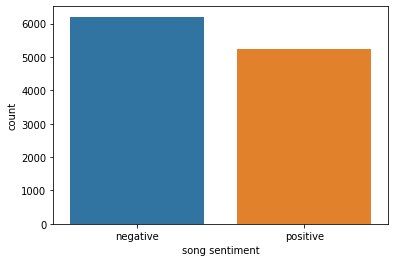

In [136]:
def to_sentiment_2classes(valence):
  if valence < 0.5:
    return 0
  elif valence > 0.5:
    return 1
  else:
    pass
df_en['sentiment_2classes'] = df_en.valence.apply(to_sentiment_2classes)
#df_en.sentiment_2classes = df_en.sentiment_2classes.astype(int)
# Plot the score distribution after conversion
ax = sns.countplot(df_en.sentiment_2classes)
class_names = ['negative', 'positive']
plt.xlabel('song sentiment')
ax.set_xticklabels(class_names)

In [140]:
print('negative songs shape:{}'.format(df_en[df_en['sentiment_2classes']==0].shape))
print('positive songs shape:{}'.format(df_en[df_en['sentiment_2classes']==1].shape))


negative songs shape:(6207, 20)
positive songs shape:(5248, 20)


### 3classes sentiment dataset

In [143]:
#------ To generate 3 classes, we need to add valence == 0.5 back to df ------#
# remove non-English llyrics
df_mid_valence = df_mid_valence.drop(14578)
# change all text to lower case
df_mid_valence['lyrics'] = [word.lower() for word in df_mid_valence['lyrics']]
# add valence == 0.5 back to df
df_en_all_valence = df_en.append(df_mid_valence, ignore_index=True, sort=False)
df_en_all_valence

,acousticness,artist,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,lyrics,mode,popularity,release date,song_title,speechiness,tempo,valence,year,sentiment_2classes
0,0.130000,James Brown The Famous Flames,0.295,171933.0,0.373,0.0,0.000000,5.0,0.641,-10.316,let's make this christmas mean something this...,1.0,11.0,2007-12-04,Lets Make Christmas Mean Something This Year ...,0.0374,172.762,0.378,2007.0,0.0
1,0.194000,Gerry The Pacemakers,0.548,186053.0,0.892,0.0,0.000000,9.0,0.160,-7.336,come over baby whole lot of shakin' goin' on ...,0.0,9.0,2008-02-11,Whole Lotta Shakin Going On,0.0654,97.195,0.814,2008.0,1.0
2,0.000369,Godhead,0.421,285907.0,0.907,0.0,0.084300,0.0,0.270,-5.836,"don't go over there, that vultures gonna get y...",1.0,15.0,2001-01-01,I Sell Society,0.0860,179.440,0.186,2001.0,0.0
3,0.037100,Jimmy Eat World,0.643,165853.0,0.849,0.0,0.000000,2.0,0.058,-5.428,"hey, don't write yourself off yet it's only i...",1.0,78.0,2001-07-17,The Middle,0.0526,162.152,0.903,2001.0,1.0
4,0.000481,Papa Roach,0.589,199907.0,0.890,1.0,0.000820,4.0,0.201,-3.719,"cut my life into pieces, this is my last reso...",0.0,80.0,2001-04-25,Last Resort,0.0603,90.598,0.692,2001.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11464,0.069700,The Frights,0.565,170299.0,0.618,0.0,0.000064,1.0,0.509,-11.316,"one, two, three, four for if we ain't got t...",0.0,62.0,2016-02-12,Tungs,0.1040,106.337,0.500,2016.0,NaN
11465,0.007740,Stars in Coma,0.407,192628.0,0.709,0.0,0.210000,6.0,0.297,-8.730,pressure on my mind so i’m tryna relax pop a ...,1.0,0.0,2016-06-15,Soldiers,0.0342,140.024,0.500,2016.0,NaN
11466,0.020700,Hollywood Undead,0.547,204160.0,0.937,1.0,0.000000,7.0,0.216,-2.694,"can't stop, i need some help fuck you, i'm by...",0.0,55.0,2011,Levitate,0.0867,128.059,0.500,2011.0,NaN
11467,0.201000,Drake,0.864,192932.0,0.477,1.0,0.000000,10.0,0.182,-5.786,"yeah, i'm outside in an amg right outside, tt...",1.0,73.0,2020-05-01,Time Flies,0.2240,86.460,0.500,2020.0,NaN


/Users/iriszzwanzig/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

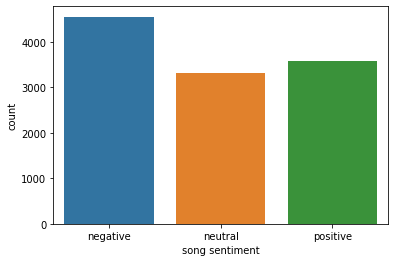

In [150]:
def to_sentiment_3classes(valence):
  if valence < 0.4:
    return 0
  elif valence > 0.6:
    return 2
  else:
    return 1
df_en_all_valence['sentiment_3classes'] = df_en_all_valence.valence.apply(to_sentiment_3classes)

# Plot the score distribution after conversion
ax = sns.countplot(df_en_all_valence.sentiment_3classes)
class_names = ['negative', 'neutral','positive']
plt.xlabel('song sentiment')
ax.set_xticklabels(class_names)

In [151]:
print('negative songs shape:{}'.format(df_en_all_valence[df_en_all_valence['sentiment_3classes']==0].shape))
print('neutral songs shape:{}'.format(df_en_all_valence[df_en_all_valence['sentiment_3classes']==1].shape))
print('positive songs shape:{}'.format(df_en_all_valence[df_en_all_valence['sentiment_3classes']==2].shape))

negative songs shape:(4558, 21)
neutral songs shape:(3325, 21)
positive songs shape:(3586, 21)


In [194]:
df_en_all_valence.to_csv('all_songs_dataset.csv')

In [193]:
df_en_all_valence

,acousticness,artist,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,...,mode,popularity,release date,song_title,speechiness,tempo,valence,year,sentiment_2classes,sentiment_3classes
0,0.130000,James Brown The Famous Flames,0.295,171933.0,0.373,0.0,0.000000,5.0,0.641,-10.316,...,1.0,11.0,2007-12-04,Lets Make Christmas Mean Something This Year ...,0.0374,172.762,0.378,2007.0,0.0,0
1,0.194000,Gerry The Pacemakers,0.548,186053.0,0.892,0.0,0.000000,9.0,0.160,-7.336,...,0.0,9.0,2008-02-11,Whole Lotta Shakin Going On,0.0654,97.195,0.814,2008.0,1.0,2
2,0.000369,Godhead,0.421,285907.0,0.907,0.0,0.084300,0.0,0.270,-5.836,...,1.0,15.0,2001-01-01,I Sell Society,0.0860,179.440,0.186,2001.0,0.0,0
3,0.037100,Jimmy Eat World,0.643,165853.0,0.849,0.0,0.000000,2.0,0.058,-5.428,...,1.0,78.0,2001-07-17,The Middle,0.0526,162.152,0.903,2001.0,1.0,2
4,0.000481,Papa Roach,0.589,199907.0,0.890,1.0,0.000820,4.0,0.201,-3.719,...,0.0,80.0,2001-04-25,Last Resort,0.0603,90.598,0.692,2001.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11464,0.069700,The Frights,0.565,170299.0,0.618,0.0,0.000064,1.0,0.509,-11.316,...,0.0,62.0,2016-02-12,Tungs,0.1040,106.337,0.500,2016.0,NaN,1
11465,0.007740,Stars in Coma,0.407,192628.0,0.709,0.0,0.210000,6.0,0.297,-8.730,...,1.0,0.0,2016-06-15,Soldiers,0.0342,140.024,0.500,2016.0,NaN,1
11466,0.020700,Hollywood Undead,0.547,204160.0,0.937,1.0,0.000000,7.0,0.216,-2.694,...,0.0,55.0,2011,Levitate,0.0867,128.059,0.500,2011.0,NaN,1
11467,0.201000,Drake,0.864,192932.0,0.477,1.0,0.000000,10.0,0.182,-5.786,...,1.0,73.0,2020-05-01,Time Flies,0.2240,86.460,0.500,2020.0,NaN,1


## Generate lyrics with comma separation

In [2]:
spotify_df = pd.read_csv('data.csv')
df = spotify_df.drop(columns = ['id'])

# remove punctuation in name & artist
def remove_punctuation(txt):
    txt_nonpunc =''.join([c for c in txt if c not in string.punctuation])
    return txt_nonpunc
df['name'] = df['name'].apply(lambda x:remove_punctuation(x))
df['artists'] = df['artists'].apply(lambda x:remove_punctuation(x))

In [6]:
%pip install lyricsgenius
from lyricsgenius import Genius
from datetime import datetime

Genius_api = Genius('PqFpIzApYNaLH7mF-sUX4cIq_lSgu148NNQuEIZ4NB9Y1rQp0iyKoEE2c4PqOdnH',sleep_time=0.001, verbose=False)

Note: you may need to restart the kernel to use updated packages.


In [13]:
df_2001 = df[ 2001 <= df['year'] ]

In [15]:
# mapping Genius lyrics with spotify dataset based on song title and artist--df_2001
import re
all_song_with_comma_df = pd.DataFrame()

start_time = datetime.now()
print("Started at {}".format(start_time))

for i in range(0,len(df_2001)):
    rolling_pct = int((i/len(df_2001))*100) #check the progress
    print(str(rolling_pct) + "% complete." + " Collecting Record " + str(i) +" of " +
          str(len(df_2001)) +". Year " + str(df_2001.iloc[i]['year']) + "." + " Currently collecting " + 
          df_2001.iloc[i]['name'] + " by " + df_2001.iloc[i]['artists'] + " "*50, end="\r")
    title = df_2001.iloc[i]['name']
    title = re.sub("and","&",title)  # "and" is "&" in Genius
    artist = df_2001.iloc[i]['artists']
    artist = re.sub("and","&",artist) # "and" is "&" in Genius
    
    try:
        song = Genius_api.search_song(title,artist)
        song_lyrics = re.sub("\n", ",", song.lyrics) ###Remove newline breaks, we won't need them.

    except:
        song_lyrics = "null"

        
    row = {
        #"album": song_album,
        "lyrics": song_lyrics,
        #"writers": song_writer_artists,
        "song title": df_2001.iloc[i]['name'],
        "artist": df_2001.iloc[i]['artists'],
        "release date": df_2001.iloc[i]['release_date'],
        "year": df_2001.iloc[i]['year'],
        "popularity": df_2001.iloc[i]['popularity'],
        "acousticness": df_2001.iloc[i]['acousticness'],
        "danceability": df_2001.iloc[i]['danceability'],
        "duration_ms": df_2001.iloc[i]['duration_ms'],
        "energy": df_2001.iloc[i]['energy'],
        "explicit": df_2001.iloc[i]['explicit'],
        "instrumentalness": df_2001.iloc[i]['instrumentalness'],
        "key": df_2001.iloc[i]['key'],
        "liveness": df_2001.iloc[i]['liveness'],
        "loudness": df_2001.iloc[i]['loudness'],
        "mode": df_2001.iloc[i]['mode'],
        "speechiness": df_2001.iloc[i]['speechiness'],
        "tempo": df_2001.iloc[i]['tempo'],
        "valence": df_2001.iloc[i]['valence'],

    }
    all_song_with_comma_df = all_song_with_comma_df.append(row,ignore_index=True)
    

end_time = datetime.now()
print("\nCompleted at {}".format(start_time))
print("Total time to collect: {}".format(end_time - start_time))

Started at 2021-05-29 01:03:39.264240
99% complete. Collecting Record 36396 of 36397. Year 2020. Currently collecting Improvisations by Roger Fly                                                                                                                                                                         lic Relief                                                                                                                  Kahakalau Charles Michael Brotman Moe Keale 2004 Hawaii Music Awards Compilation Of The Year                                                                                   
Completed at 2021-05-29 01:03:39.264240
Total time to collect: 19:00:43.874649


In [10]:
# Check the lyrics
all_song_with_comma_df.iloc[0]['lyrics']

"[Intro],I don't want a lot for Christmas,There is just one thing I need,I don't care about the presents,Underneath the Christmas tree,I just want you for my own,More than you could ever know,Make my wish come true,All I want for Christmas is you, yeah,,[Verse 1],I don't want a lot for Christmas,There is just one thing I need (And I),Don't care about the presents,Underneath the Christmas tree,I don't need to hang my stocking,There upon the fireplace (Ah),Santa Claus won't make me happy,With a toy on Christmas Day,,[Chorus],I just want you for my own (Ooh),More than you could ever know (Ooh),Make my wish come true,All I want for Christmas is you,You, baby,[Verse 2],Oh, I won't ask for much this Christmas,I won't even wish for snow (And I),I'm just gonna keep on waiting,Underneath the mistletoe,I won't make a list and send it,To the North Pole for Saint Nick (Ah),I won't even stay awake to,Hear those magic reindeer click,,[Chorus],'Cause I just want you here tonight (Ooh),Holding on to m

In [17]:
# filter songs with lyrics
songs_with_lyrics_comma = all_song_with_comma_df[all_song_with_comma_df['lyrics'] !='null']  
display(all_song_with_comma_df.shape)
display(songs_with_lyrics_comma.shape)

(36397, 19)

(23095, 19)

In [191]:
songs_with_lyrics_comma.to_csv("all_songs_after2001_comma.csv")

## Lyrics with comma--Preprocessing

### 2classes sentiment dataset

In [158]:
df_comma = songs_with_lyrics_comma.copy()
df_comma = df_comma[df_comma['lyrics'].str.contains('Intro|Chorus|Verse')]
df_comma = df_comma[df_comma['lyrics'].str.contains('Last updated|feat|Version')==False]
df_comma = df_comma[df_comma['song title'].str.contains('Unreleased|Remaster|Version|Live|Rapper|Demo|Mixed')==False]


#------ remove duplicate ------#
df_comma = df_comma.rename(columns={'song title': 'song_title'})
# Any duplicate song_title?
print('Total rows: ', len(df_comma))
print('Unique rows based on song title', len(df_comma.song_title.unique()))

# Drop duplicate data based on song_title, artist, year
df_comma = df_comma.drop_duplicates(['song_title', 'artist', 'year'])
print('Total rows after removing duplicates songs: ', len(df_comma))

#------ remove valence == 0.5 ------#
df_comma_mid_valence = df_comma[df_comma['valence'] == 0.5]
df_comma = df_comma.drop(df_comma[df_comma.valence == 0.5].index).reset_index(drop=True)
print('Total rows after removing valence is 0.5: ',len(df_comma))

#------ Remove non-English lyrics ------#
indexes_to_drop = []
except_id = []
for i in range(len(df_comma)):
  try:
    text_content = df_comma.lyrics[i]
    _, _, _, detected_language = cld2.detect(text_content, returnVectors=True)
    if(len(detected_language) != 1 or detected_language[0][3] != 'en'):
        indexes_to_drop.append(i)
    #print('Lyrics not in English: {}'.format(i))
  except:
    except_id.append(i)
    #print('Not in data: {}'.format(i))

print('Num of Lyrics not all in English: {}'.format(len(indexes_to_drop)))
print('Num of Data with KeyError: {}'.format(len(except_id)))
indexes_to_keep = set(range(df_comma.shape[0])) - set(indexes_to_drop) - set(except_id)
df_en_comma = df_comma.take(list(indexes_to_keep)).reset_index(drop=True)
print('Total English songs: ', len(df_en_comma))


#------ Normalize slang words based on dictionary ------#
with open('slang_meaning.csv') as file:
    reader = csv.reader(file)
    next(reader)
    dictionary = {rows[0]: rows[1] for rows in reader}
#print(df_en)
df_edit = df_en.replace({'lyrics': dictionary})
# check how many songs were edited
merged_data = df_en[~df_en.apply(tuple, 1).isin(df_edit.apply(tuple, 1))]
merged_data



Total rows:  13791
Unique rows based on song title 11260
Total rows after removing duplicates songs:  12784
Total rows after removing valence is 0.5:  12769
Num of Lyrics not all in English: 2262
Num of Data with KeyError: 2
Total English songs:  10505


,acousticness,artist,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,lyrics,mode,popularity,release date,song_title,speechiness,tempo,valence,year,sentiment_2classes


/Users/iriszzwanzig/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'negative'), Text(1, 0, 'positive')]

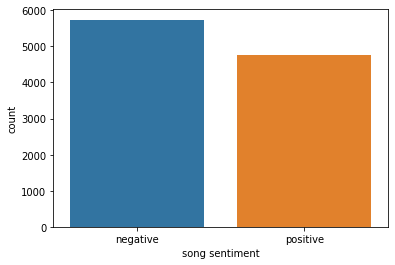

In [159]:

def to_sentiment_2classes(valence):
  if valence < 0.5:
    return 0
  elif valence > 0.5:
    return 1
  else:
    pass
df_en_comma['sentiment_2classes'] = df_en_comma.valence.apply(to_sentiment_2classes)

# Plot the score distribution after conversion
ax = sns.countplot(df_en_comma.sentiment_2classes)
class_names = ['negative', 'positive']
plt.xlabel('song sentiment')
ax.set_xticklabels(class_names) 

In [160]:
print('negative songs shape:{}'.format(df_en_comma[df_en_comma['sentiment_2classes']==0].shape))
print('positive songs shape:{}'.format(df_en_comma[df_en_comma['sentiment_2classes']==1].shape))


negative songs shape:(5738, 20)
positive songs shape:(4767, 20)


### 3classes sentiment dataset

In [165]:
#------ To generate 3 classes, we need to add valence == 0.5 back to df ------#
# add valence == 0.5 back to df
df_en_comma_all_valence = df_en_comma.append(df_comma_mid_valence, ignore_index=True, sort=False)

In [192]:
df_en_comma_all_valence

,acousticness,artist,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,...,mode,popularity,release date,song_title,speechiness,tempo,valence,year,sentiment_2classes,sentiment_3classes
0,0.13000,James Brown The Famous Flames,0.295,171933.0,0.373,0.0,0.000000,5.0,0.6410,-10.316,...,1.0,11.0,2007-12-04,Lets Make Christmas Mean Something This Year ...,0.0374,172.762,0.378,2007.0,0.0,0
1,0.19400,Gerry The Pacemakers,0.548,186053.0,0.892,0.0,0.000000,9.0,0.1600,-7.336,...,0.0,9.0,2008-02-11,Whole Lotta Shakin Going On,0.0654,97.195,0.814,2008.0,1.0,2
2,0.00176,Green Day,0.206,144627.0,0.990,0.0,0.000081,10.0,0.3350,-3.565,...,1.0,36.0,2017-11-17,2000 Light Years Away,0.1300,187.433,0.666,2017.0,1.0,2
3,0.01250,Selena Gomez The Scene,0.627,234347.0,0.810,0.0,0.000031,2.0,0.1110,-5.296,...,0.0,34.0,2019-07-12,A Year Without Rain,0.0431,119.980,0.409,2019.0,0.0,1
4,0.00060,Busted,0.570,196387.0,0.770,0.0,0.000000,11.0,0.0831,-8.431,...,1.0,19.0,2020-07-03,Year 3000,0.0471,107.013,0.832,2020.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10515,0.20100,Drake,0.864,192932.0,0.477,1.0,0.000000,10.0,0.1820,-5.786,...,1.0,73.0,2020-05-01,Time Flies,0.2240,86.460,0.500,2020.0,NaN,1
10516,0.05410,Usher,0.797,273760.0,0.538,0.0,0.000008,8.0,0.0899,-6.006,...,1.0,48.0,2004-03-23,Seduction,0.0608,128.068,0.500,2004.0,NaN,1
10517,0.05950,Carrie Underwood,0.456,204093.0,0.874,0.0,0.000011,10.0,0.1110,-4.129,...,0.0,56.0,2015-10-23,Dirty Laundry,0.1140,200.179,0.500,2015.0,NaN,1
10518,0.25100,Mariah Carey Hex Hector Mac Quayle,0.553,251560.0,0.877,0.0,0.008360,8.0,0.3660,-6.927,...,1.0,16.0,2002-01-13,Through The Rain Hex HectorMac Quayle Radio Edit,0.0355,132.002,0.500,2002.0,NaN,1


/Users/iriszzwanzig/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

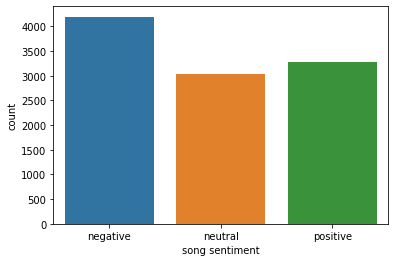

In [166]:
def to_sentiment_3classes(valence):
  if valence < 0.4:
    return 0
  elif valence > 0.6:
    return 2
  else:
    return 1
df_en_comma_all_valence['sentiment_3classes'] = df_en_comma_all_valence.valence.apply(to_sentiment_3classes)

# Plot the score distribution after conversion
ax = sns.countplot(df_en_comma_all_valence.sentiment_3classes)
class_names = ['negative', 'neutral','positive']
plt.xlabel('song sentiment')
ax.set_xticklabels(class_names)

In [167]:
print('negative songs shape:{}'.format(df_en_comma_all_valence[df_en_comma_all_valence['sentiment_3classes']==0].shape))
print('neutral songs shape:{}'.format(df_en_comma_all_valence[df_en_comma_all_valence['sentiment_3classes']==1].shape))
print('positive songs shape:{}'.format(df_en_comma_all_valence[df_en_comma_all_valence['sentiment_3classes']==2].shape))


negative songs shape:(4197, 21)
neutral songs shape:(3034, 21)
positive songs shape:(3289, 21)


In [196]:
df_en_comma_all_valence

,acousticness,artist,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,...,mode,popularity,release date,song_title,speechiness,tempo,valence,year,sentiment_2classes,sentiment_3classes
0,0.13000,James Brown The Famous Flames,0.295,171933.0,0.373,0.0,0.000000,5.0,0.6410,-10.316,...,1.0,11.0,2007-12-04,Lets Make Christmas Mean Something This Year ...,0.0374,172.762,0.378,2007.0,0.0,0
1,0.19400,Gerry The Pacemakers,0.548,186053.0,0.892,0.0,0.000000,9.0,0.1600,-7.336,...,0.0,9.0,2008-02-11,Whole Lotta Shakin Going On,0.0654,97.195,0.814,2008.0,1.0,2
2,0.00176,Green Day,0.206,144627.0,0.990,0.0,0.000081,10.0,0.3350,-3.565,...,1.0,36.0,2017-11-17,2000 Light Years Away,0.1300,187.433,0.666,2017.0,1.0,2
3,0.01250,Selena Gomez The Scene,0.627,234347.0,0.810,0.0,0.000031,2.0,0.1110,-5.296,...,0.0,34.0,2019-07-12,A Year Without Rain,0.0431,119.980,0.409,2019.0,0.0,1
4,0.00060,Busted,0.570,196387.0,0.770,0.0,0.000000,11.0,0.0831,-8.431,...,1.0,19.0,2020-07-03,Year 3000,0.0471,107.013,0.832,2020.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10515,0.20100,Drake,0.864,192932.0,0.477,1.0,0.000000,10.0,0.1820,-5.786,...,1.0,73.0,2020-05-01,Time Flies,0.2240,86.460,0.500,2020.0,NaN,1
10516,0.05410,Usher,0.797,273760.0,0.538,0.0,0.000008,8.0,0.0899,-6.006,...,1.0,48.0,2004-03-23,Seduction,0.0608,128.068,0.500,2004.0,NaN,1
10517,0.05950,Carrie Underwood,0.456,204093.0,0.874,0.0,0.000011,10.0,0.1110,-4.129,...,0.0,56.0,2015-10-23,Dirty Laundry,0.1140,200.179,0.500,2015.0,NaN,1
10518,0.25100,Mariah Carey Hex Hector Mac Quayle,0.553,251560.0,0.877,0.0,0.008360,8.0,0.3660,-6.927,...,1.0,16.0,2002-01-13,Through The Rain Hex HectorMac Quayle Radio Edit,0.0355,132.002,0.500,2002.0,NaN,1


In [197]:
df_en_comma_all_valence.to_csv('all_songs_comma_dataset.csv')